# Prerequisite

Installed [dials](https://dials.github.io/installation.html) on XStream:
```
cd ~/Toolkit
tar -xf dials-v1-10-0-linux-x86_64.tar.xz
cd dials-installer/
./install --prefix=/path/dials-installer
source dials_env.sh # put that in .bashrc
libtbx.python -m pip install IPython
```

# Step 0 - XDS
can be found in `$WORK/diffuse/A3+`, all `A3_4_*.cbf` files and under directory `A3_4_xds`.

# Step 1 - Generate system files

## Prepare files
### .cbf images to .npy arrays
see  `WORK/diffuse/tools/cbf2npy.sh`
We run `./tools/cbf2npy.sh ./A3+/ ./jobs/A3_4/cbf_as_npy/ A3_4`.
### mask beam-stop
added this to `INIT.LP`
```
 TRUSTED_REGION=    0.00    1.05
 UNTRUSTED_ELLIPSE=  1145.  1310.    1175.  1345.   (X1,X2, Y1,Y2)
 UNTRUSTED_RECTANGLE=    487.   495.       0.  2528.   (X1,X2, Y1,Y2)
 UNTRUSTED_RECTANGLE=    981.   989.       0.  2528.   (X1,X2, Y1,Y2)
 UNTRUSTED_RECTANGLE=   1475.  1483.       0.  2528.   (X1,X2, Y1,Y2)
 UNTRUSTED_RECTANGLE=   1969.  1977.       0.  2528.   (X1,X2, Y1,Y2)
 UNTRUSTED_RECTANGLE=      0.  2464.     195.   213.   (X1,X2, Y1,Y2)
 UNTRUSTED_RECTANGLE=      0.  2464.     407.   425.   (X1,X2, Y1,Y2)
 UNTRUSTED_RECTANGLE=      0.  2464.     619.   637.   (X1,X2, Y1,Y2)
 UNTRUSTED_RECTANGLE=      0.  2464.     831.   849.   (X1,X2, Y1,Y2)
 UNTRUSTED_RECTANGLE=      0.  2464.    1043.  1061.   (X1,X2, Y1,Y2)
 UNTRUSTED_RECTANGLE=      0.  2464.    1255.  1273.   (X1,X2, Y1,Y2)
 UNTRUSTED_RECTANGLE=      0.  2464.    1467.  1485.   (X1,X2, Y1,Y2)
 UNTRUSTED_RECTANGLE=      0.  2464.    1679.  1697.   (X1,X2, Y1,Y2)
 UNTRUSTED_RECTANGLE=      0.  2464.    1891.  1909.   (X1,X2, Y1,Y2)
 UNTRUSTED_RECTANGLE=      0.  2464.    2103.  2121.   (X1,X2, Y1,Y2)
 UNTRUSTED_RECTANGLE=      0.  2464.    2315.  2333.   (X1,X2, Y1,Y2)
 UNTRUSTED_QUADRILATERAL=  1245  1320    2464  1340    2464  1230    1245  1210   (4 XY-pairs)
 ```

## build reference dictionary `system.pickle`
```
cd ~/Toolkit/diffuse/pipeline
dials.python generate_system.py WORK/diffuse/A3+/A3_4_xds/ WORK/diffuse/jobs/A3_4/exp/ npy
```

![](mask_and_scales.png)


## Step 2 - Indexing all pixels
Installing missing libraries on XStream (e.g. pandas): `dials.python -m pip install pandas`

Now realizing that `index.py` might like it better if all initial .cbf images would be better off in their own subdirectory `/cstor/stanford/levittm/users/fpoitevi/diffuse/A3+/A3_4_cbf/`

```
dials.python index.py /cstor/stanford/levittm/users/fpoitevi/diffuse/jobs/A3_4/exp/ /cstor/stanford/levittm/users/fpoitevi/diffuse/jobs/A3_4/cbf_as_npy/
```
 
<details><summary>slurm script</summary>```
#!/bin/bash
#
#SBATCH --job-name=gdup
#SBATCH --output=gdup%j.out
#SBATCH --error=gdup.%j.err
#
#SBATCH --time=48:00:00
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --gres gpu:1

srun ./run.sh
```
</details>

see `/cstor/stanford/levittm/users/fpoitevi/diffuse/jobs/A3_4/exp/indexed/`

![index](index.png)

This plot looks a bit pathological, as we see an oscillatory behavior in the discrepancy between XDS and current indexing, on top of which spikes appear somewhat regularly. As suggested by Ariana, let's look at the unit cell dimension parameters (lengths and volume) behavior. All directions experience large variations, although a=b in average, with similar deviation


Loading the pickle jar...
a = 404.392739908 +/- 6.98661338688 A  ( 1.72768022207 %)
b = 404.392803832 +/- 6.98661460404 A  ( 1.72768024996 %)
c = 174.792572337 +/- 3.00510212246 A  ( 1.71923902846 %)
V = 28610039.1367 +/- 1496874.99891 A3 ( 5.23199214007 %)


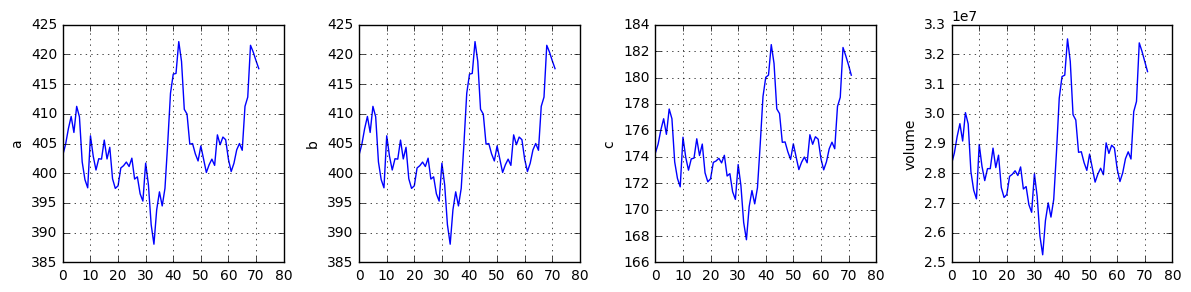

In [100]:
print "Loading the pickle jar..."
system = pickle.load(open("system.pickle"))
#
nbatch= range(system['A_batch'].shape[0]); dim=['a','b','c']
for i in range(3): # looping through a,b,c
    ref_vecs = np.array([np.linalg.norm(system['A_batch'][batch][i]) for batch in nbatch])
    ref_mean = np.mean(ref_vecs); ref_std = np.std(ref_vecs); ratio = ref_std/ref_mean
    print dim[i],"=", ref_mean, "+/-", ref_std, "A  (", 100*ratio,"%)"
volume = np.array([np.dot(system['A_batch'][batch][0],np.cross(system['A_batch'][batch][1],system['A_batch'][batch][2])) for batch in nbatch])
print "V =",np.mean(volume), "+/-", np.std(volume), "A3 (", 100*np.std(volume)/np.mean(volume),"%)"
#
plt.figure(figsize=(12, 3), dpi= 160, facecolor='w', edgecolor='k'); nrow=1; ncol=4
for i in range(3):
    plt.subplot(nrow,ncol,i+1); plt.ylabel(dim[i]); plt.grid()
    plt.plot(np.array([np.linalg.norm(system['A_batch'][batch][i]) for batch in nbatch]))
plt.subplot(nrow,ncol,4); plt.ylabel('volume'); plt.grid()
plt.plot(volume)
plt.tight_layout(); plt.show()

# Step 3 - Provide map specs

Based on the info in `INTEGRATE.LP`:
```
RESOLUTION RANGE RECORDED BY DETECTOR (ANGSTROM)    40.007     2.928
```

```
[fpoitevi@xstream-ln02 ~/Toolkit/diffuse/pipeline]$ dials.python amend_system.py /cstor/stanford/levittm/users/fpoitevi/diffuse/jobs/A3_4/exp/system.pickle
Maximum resolution of final map: 3.0
Subsampling between Bragg peaks: 3
```

On 07/03/18, re-ran this with much lower resolution:

```
[fpoitevi@xstream-ln01 ~/Toolkit/diffuse/pipeline]$ dpython amend_system.py /cstor/stanford/levittm/users/fpoitevi/diffuse/jobs/A3_4/exp/system.pickle
Maximum resolution of final map: 8
Subsampling between Bragg peaks: 3
```

# Step 4 - Masking Bragg peaks

In June 2018, we did this the first time

for ibatch in 0:71
```
dials.python mask_bragg.py generate /cstor/stanford/levittm/users/fpoitevi/diffuse/jobs/A3_4/exp/system.pickle 3 5 420 $ibatch
```
```
dials.python mask_bragg.py compile /cstor/stanford/levittm/users/fpoitevi/diffuse/jobs/A3_4/exp/system.pickle
```

On 07/03/18, we do it again with updated scripts (see email with Ariana), and parameters
First, we temporarily rename `/cstor/stanford/levittm/users/fpoitevi/diffuse/jobs/A3_4/exp/temp/` to `temp.old`, and store the logfiles from previous runs, then:

for ibatch in 0:71
```
python mask_bragg.py generate /cstor/stanford/levittm/users/fpoitevi/diffuse/jobs/A3_4/exp/system.pickle 2 420 $ibatch
```
```
python mask_bragg.py compile /cstor/stanford/levittm/users/fpoitevi/diffuse/jobs/A3_4/exp/system.pickle
```


We can look at the combined mask below:

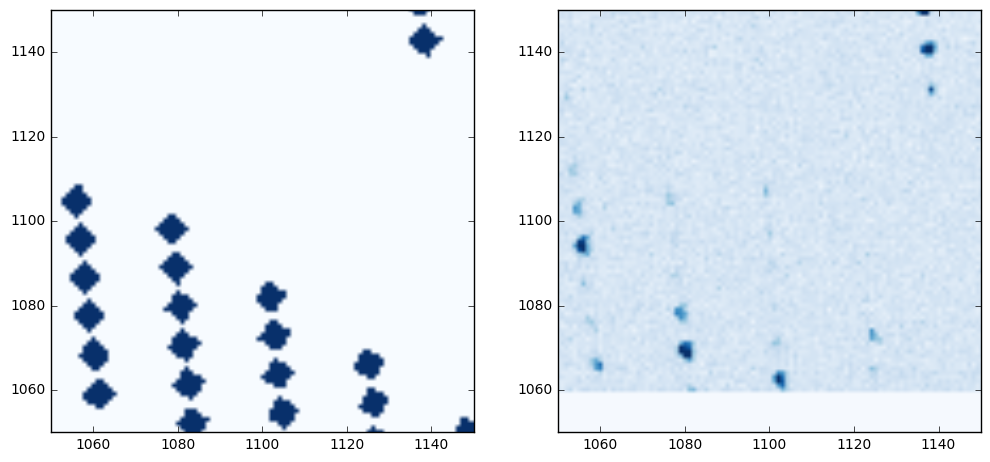

In [7]:
num = 900
img = np.load("cbf_as_npy/A3_4_00%s.npy" %num)
system = pickle.load(open("exp/system.pickle", "rb"))
mask = io.loadh("exp/combined_braggmasks.h5")["arr_%s" %(num-1)]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))


ax1.imshow(mask.reshape(system['shape']), cmap='Blues', vmax=1)
ax2.imshow(img.reshape(system['shape']), cmap='Blues', vmax=100)

for ax in [ax1, ax2]:
    ax.set_xlim(1050,1150)
    ax.set_ylim(1050,1150)
    #ax.set_xlim(0,2500)
    #ax.set_ylim(0,2500)

and

In [2]:
%matplotlib inline
import mdtraj
from mdtraj import io
import cPickle as pickle
import numpy as np
import matplotlib, sys, time, glob
matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [17]:
import sys
print(sys.version)

2.7.13 (default, Apr 23 2017, 16:50:35) 
[GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)]
